<a href="https://colab.research.google.com/github/MLRG-CEFET-RJ/attention-mechanism/blob/main/TemperatureSelfAttention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
from numpy import array
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import requests, zipfile, io
import matplotlib.pyplot as plt
import os

import torch.nn.functional as F

Baixar o arquivo com o conjunto de dados.

In [82]:
zip_file_url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip'

r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

Carregar o arquivo (em formato CSV) para um objeto

In [83]:
df = pd.read_csv('jena_climate_2009_2016.csv')

Visualização dos dados

In [84]:
df.head(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


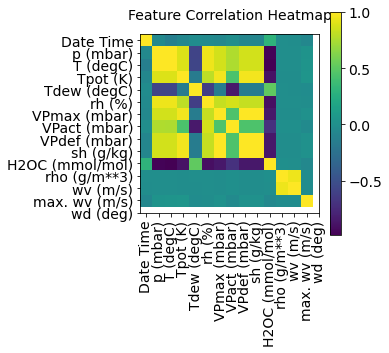

In [41]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)


Preparação dos dados

In [85]:
print(df.shape)

# slice [start:stop:step], starting from index 5, take every 6th record.
df = df[5::6]

print(df.shape)

(420551, 15)
(70091, 15)


In [86]:
date_time = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

Sumário estatístico da temperatura

In [44]:
temperature = df['T (degC)']
temperature.describe()

count    70091.000000
mean         9.450482
std          8.423384
min        -22.760000
25%          3.350000
50%          9.410000
75%         15.480000
max         37.280000
Name: T (degC), dtype: float64

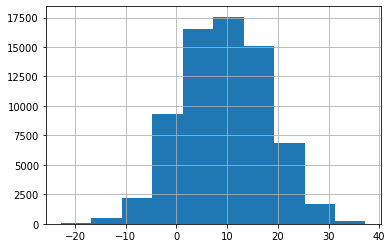

In [ ]:
temperature.hist()

In [87]:
train_set = temperature[:1200]
valid_set = temperature[69000:69500]
test_set = temperature[69500:]
print('Proporção de exemplos para treino: {:.2f}%'.format(len(train_set)/len(temperature)))
print('Proporção de exemplos para validação: {:.2f}%'.format(len(valid_set)/len(temperature)))
print('Proporção de exemplos para teste: {:.2f}%'.format(len(valid_set)/len(temperature)))

Proporção de exemplos para treino: 0.02%
Proporção de exemplos para validação: 0.01%
Proporção de exemplos para teste: 0.01%


Janelas deslizantes

In [88]:
def window_generator(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        
        end_ix = i + n_steps
        
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

In [89]:
n_steps = 3
seq = np.array([10,20,30,40,50,60,70,80,90])
seq_train_x, seq_train_y = window_generator(seq, n_steps)

df = pd.DataFrame(seq_train_x)
df.columns =['t_3', 't_2', 't_1']
df['target'] = seq_train_y.tolist()

df.head()

,t_3,t_2,t_1,target
0,10,20,30,40
1,20,30,40,50
2,30,40,50,60
3,40,50,60,70
4,50,60,70,80


In [90]:
n_steps = 3
train_x, train_y = window_generator(train_set.values, n_steps)
valid_x, valid_y = window_generator(valid_set.values, n_steps)
test_x, test_y = window_generator(test_set.values, n_steps)

In [91]:
class SelfAttention(nn.Module):
  def __init__(self, k, heads):
    super().__init__()
    self.k, self.heads = k, heads

    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues  = nn.Linear(k, k * heads, bias=False)   
    self.unifyheads = nn.Linear(heads * k, k)

  def forward(self, x):
      b, t, k = x.size()
      h = self.heads

      queries = self.toqueries(x).view(b, t, h, k)
      keys    = self.tokeys(x)   .view(b, t, h, k)
      values  = self.tovalues(x) .view(b, t, h, k)


      keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
      queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
      values = values.transpose(1, 2).contiguous().view(b * h, t, k)


      queries = queries / (k ** (1/2))
      keys    = keys / (k ** (1/2))

      # - get dot product of queries and keys, and scale
      dot = torch.bmm(queries, keys.transpose(1, 2))
      # - dot has size (b*h, t, t) containing raw weights

      dot = F.softmax(dot, dim=2) 
      # - dot now contains row-wise normalized weights

      out = torch.bmm(dot, values).view(b, h, t, k)

      out = out.transpose(1, 2).contiguous().view(b, t, h * k)
      return self.unifyheads(out)



In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model1 = Net1().to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [93]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.Conv1d(3, 64, kernel_size = 1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)      

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x



In [94]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x


In [95]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x



In [96]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)      

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x



In [97]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x



In [98]:
class Net6(nn.Module):
    def __init__(self):
        super(Net6,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            SelfAttention(1, heads=2)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)     

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x



In [99]:
class Net7(nn.Module):
    def __init__(self):
        super(Net7,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )

        self.relu = nn.ReLU(inplace = True)
        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)      

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = x.view(-1, 64*1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x



In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer1 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.Conv1d(3, 64, kernel_size = 1)
        )
        self.layer2 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2)
        )
        self.layer4 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )
        self.layer5 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )
        self.layer6 = nn.Sequential(
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            SelfAttention(1, heads=2)
        )
        self.layer7 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1),
            nn.Conv1d(3, 64, kernel_size = 1),
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )
        self.layer8 = nn.Sequential(
            SelfAttention(1, heads=2),
            nn.LayerNorm(1)
        )
       
        self.relu = nn.ReLU(inplace = True)

        self.fc1 = nn.Linear(64,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self,x):
        x = self.layer2(x)
        x = self.relu(x)
        #print(x.size())
        x = x.view(-1, 64*1)
        #print(x.size())
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [100]:
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [102]:
print(model)

Net5(
  (layer1): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): SelfAttention(
      (tokeys): Linear(in_features=1, out_features=2, bias=False)
      (toqueries): Linear(in_features=1, out_features=2, bias=False)
      (tovalues): Linear(in_features=1, out_features=2, bias=False)
      (unifyheads): Linear(in_features=2, out_features=1, bias=True)
    )
    (2): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
    (3): SelfAttention(
      (tokeys): Linear(in_features=1, out_features=2, bias=False)
      (toqueries): Linear(in_features=1, out_features=2, bias=False)
      (tovalues): Linear(in_features=1, out_features=2, bias=False)
      (unifyheads): Linear(in_features=2, out_features=1, bias=True)
    )
    (4): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
  )
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


In [103]:
class Dataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        item = torch.as_tensor(item, dtype = torch.float32)
        label = torch.as_tensor(label, dtype = torch.float32)
        return item, label

train_ds = Dataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1), train_y)
valid_ds = Dataset(valid_x.reshape(valid_x.shape[0],valid_x.shape[1],1), valid_y)
test_ds = Dataset(test_x.reshape(test_x.shape[0],test_x.shape[1],1), test_y)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 32, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size = 32, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = 32, shuffle = False)

In [61]:
dataset = Dataset(train_x.reshape(train_x.shape[0],train_x.shape[1],1),train_y)
print(dataset.__getitem__(0))

(tensor([[-8.0500],
        [-8.8800],
        [-8.8100]]), tensor(-9.0500))


In [104]:
def train_model(model, batch_size, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data, target = data.to(device), target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []


  
    return  model, avg_train_losses, avg_valid_losses

In [105]:
n_epochs = 30
batch_size = 32
#model, train_loss, valid_loss = train_model(model, batch_size, n_epochs)
# descrição do teste
#test = 'Atenção/Normalização/Atenção/Normalização/Conv1d'
#results[test] =  train_loss, valid_loss

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [106]:
i = 0
for batch, (x, y) in enumerate(test_loader, 1):
  i = i + 1
  print(x[0].numpy())
  print(y.numpy())
  print(model(x))
  if i > 10:
    break
  print()

[[-8.01]
 [-6.62]
 [-4.85]]
[-2.24  0.29  0.08  1.    1.1   1.31  1.24  1.06  1.66  1.52  1.49  1.51
  1.83  1.8   2.01  1.75  1.41  1.52  1.19  1.13  0.61  1.12  2.84  3.47
  4.5   7.61  7.91  8.71  7.42  5.18  4.37  3.87]
tensor([[-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556],
        [-0.1556]], grad_fn=<AddmmBackward>)

[[5.18]
 [4.37]
 [3.87]]
[3.55 3.73 3.54 3.49 2.95 2.98 2.   2.91 3.39 4.23 3.32 4.35 4.79 5.83
 7.45 8.33 8.72 8.96 8.59 8.73 8.45 7.68 6.49

In [107]:
def predict (model):
  model.eval()  # prepare model for evaluation
  sum = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output,target)
          sum += loss


  return (sum/len(test_loader))
 

In [108]:
results = {}

In [118]:
#for i in range(1,8):
print("Net" + str(7))
model = Net6().to(device)
print (model)
model, train_loss, valid_loss = train_model(model, batch_size, n_epochs)

results["Test" + str(7)] = predict(model)
  
 

Net7
Net6(
  (layer1): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): SelfAttention(
      (tokeys): Linear(in_features=1, out_features=2, bias=False)
      (toqueries): Linear(in_features=1, out_features=2, bias=False)
      (tovalues): Linear(in_features=1, out_features=2, bias=False)
      (unifyheads): Linear(in_features=2, out_features=1, bias=True)
    )
    (2): SelfAttention(
      (tokeys): Linear(in_features=1, out_features=2, bias=False)
      (toqueries): Linear(in_features=1, out_features=2, bias=False)
      (tovalues): Linear(in_features=1, out_features=2, bias=False)
      (unifyheads): Linear(in_features=2, out_features=1, bias=True)
    )
  )
  (relu): ReLU(inplace=True)
  (fc1): Linear(in_features=64, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, ta

[ 1/30] train_loss: 31.43434 valid_loss: 40.53039
[ 2/30] train_loss: 31.43434 valid_loss: 40.53039
[ 3/30] train_loss: 31.43434 valid_loss: 40.53039


KeyboardInterrupt: ignored

In [116]:


for x in results:
  print(x,':',results[x])

Test1 : tensor(21.4491)
Test2 : tensor(21.6334)
Test3 : tensor(21.0357)
Test5 : tensor(21.0164)
Test6 : tensor(20.6184)
Test7 : tensor(21.9806)
